In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import h5py as h5

from scipy import ndimage
from scipy.stats import chisquare

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
depth = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\flow_01_WellCombinedData.csv', skiprows=6)

perforations = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\perforations.csv')
perforations['MD'] = ((perforations['TD'] + perforations['BD']) / 2) / 3.28084

perforations.index = np.searchsorted(depth['Measured Depth (mKB)'], perforations['MD'].values)
merged = pd.merge(left=depth, right=perforations, left_index=True, right_index=True, how='left')

pstring = ["P{0}-{1}".format(x, y) for x, y in zip(merged['Stage'].values, merged['Cluster'].values)]
merged['Pstring'] = pstring

merged['Clusters_per_stage'] = 0

for i, group in merged.groupby('Stage'):
    merged.loc[group.index, 'Clusters_per_stage'] = group['Cluster'].max()

merged.head()

,Channel Number,Optical Distance,Measured Depth (mKB),UTM - N,UTM - E,True Vertical Depth (mKB),Stage,Cluster,TD,BD,Shots,MD,Pstring,Clusters_per_stage
0,0,0.5,3.4,0.0,0.0,3.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
1,1,1.5,4.4,0.0,0.0,4.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
2,2,2.5,5.4,0.0,0.0,5.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
3,3,3.5,6.4,0.0,0.0,6.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
4,4,4.5,7.4,0.0,0.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0


In [3]:
fbe_file = h5.File(r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Customer Projects\Rice Energy\Belmont Project\Flow_Project\Output\FBE_Export_2017-03-02_14_31_13_00\fbe_Avg_001500_2016-04-23T074937Z.h5', 'r')

In [4]:
fdata = [fbe_file['/Acquisition/Processed/Fbe[1]/FbeData[{0}]'.format(n)] for n in range(5)]
starttime = pd.to_datetime(fbe_file['/Acquisition/Processed/Fbe[1]/FbeDataTime'].value[0] * 1000)
endtime = pd.to_datetime(fbe_file['/Acquisition/Processed/Fbe[1]/FbeDataTime'].value[-1] * 1000)
print(starttime, endtime)

2016-04-23 07:49:37 2016-04-26 12:34:37


In [5]:
fdata[0].shape

(308, 5708)

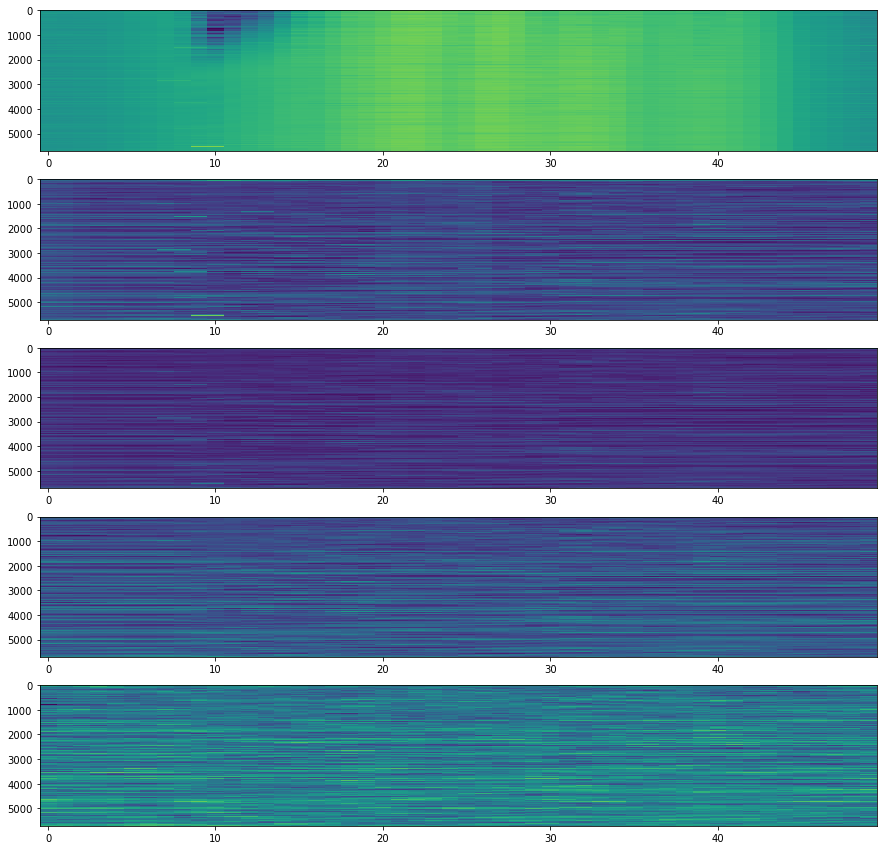

In [6]:
f, ax = plt.subplots(5, 1, figsize = (15, 15))
for a in range(5):
    ax[a].imshow(10*np.log10(fdata[a][:50, :5720].T), aspect = 'auto', cmap = 'viridis')
plt.show()

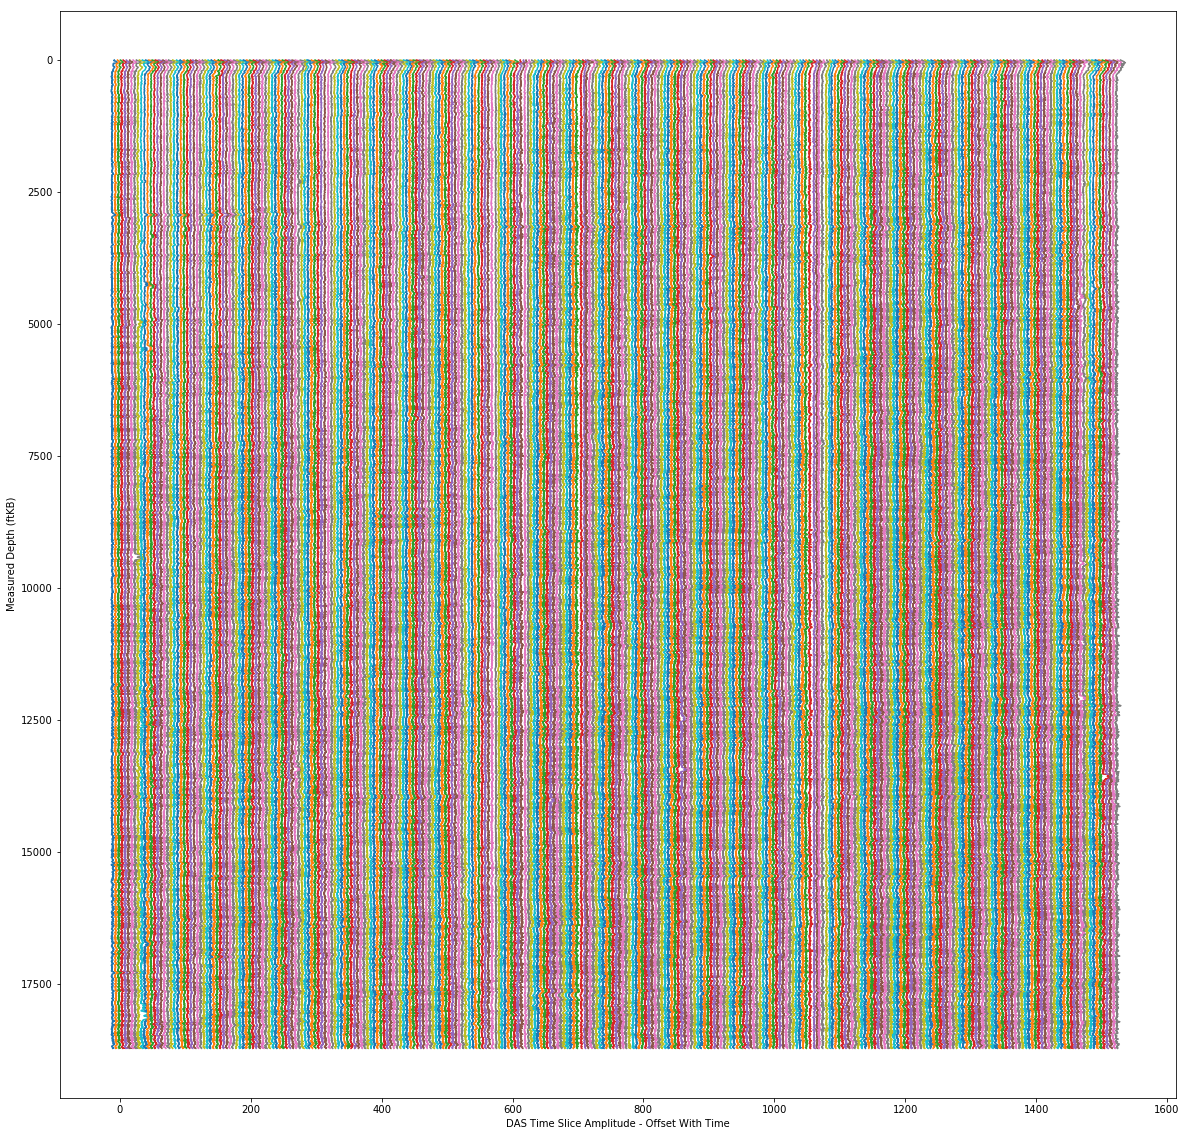

In [7]:
f, ax = plt.subplots(figsize = (20, 20))

for i in range(fdata[1].shape[0]):
    ax.plot(10*np.log10(fdata[1][i, :]) + 5*i, np.arange(fdata[1].shape[1]) * 3.28084)
ax.set_ylabel('Measured Depth (ftKB)')
ax.set_xlabel('DAS Time Slice Amplitude - Offset With Time')
f.gca().invert_yaxis()
    
plt.show()

C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


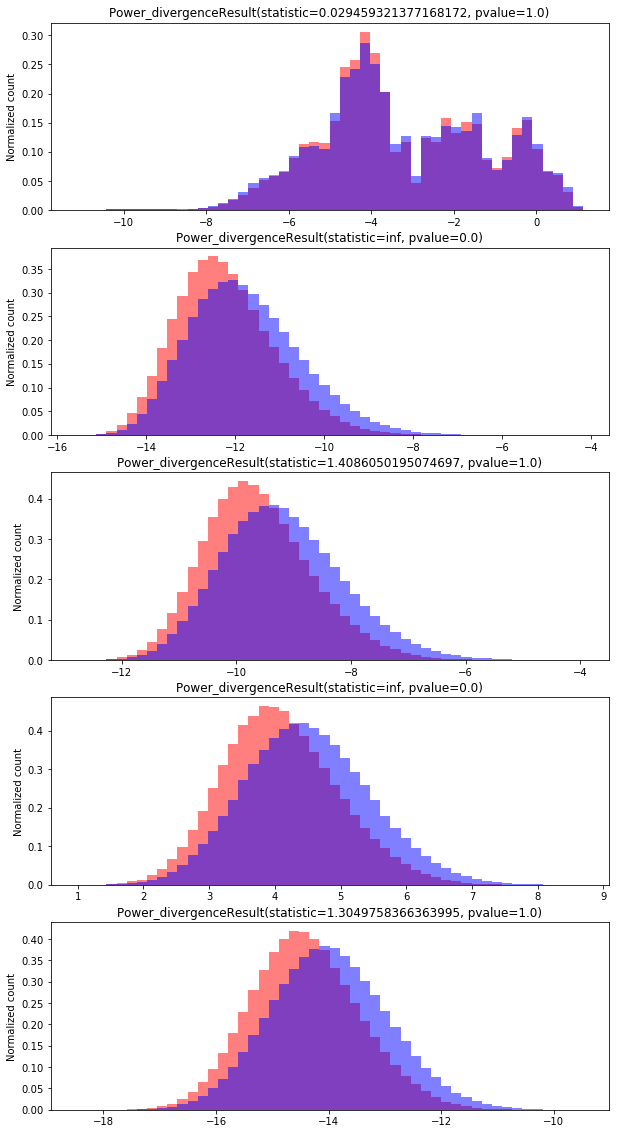

In [8]:
top_of_res = 2835
bottom_of_res = 5720
top_of_noise = 1000

f, ax = plt.subplots(5, 1, figsize = (10, 20))

start_sample = 0
end_sample = 11000

for i in range(5):
    
    noise = fdata[i][start_sample:end_sample, top_of_noise:top_of_res].flatten()
    signal = fdata[i][start_sample:end_sample, top_of_res:bottom_of_res].flatten()

    hist, bins, patches = ax[i].hist(np.nan_to_num(10*np.log10(noise)), bins = 50, alpha = 0.5, normed=True, color = 'red')
    ax[i].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i].hist(np.nan_to_num(10*np.log10(signal)), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i].set_title(chisquare(mhist, f_exp = hist))

plt.show()

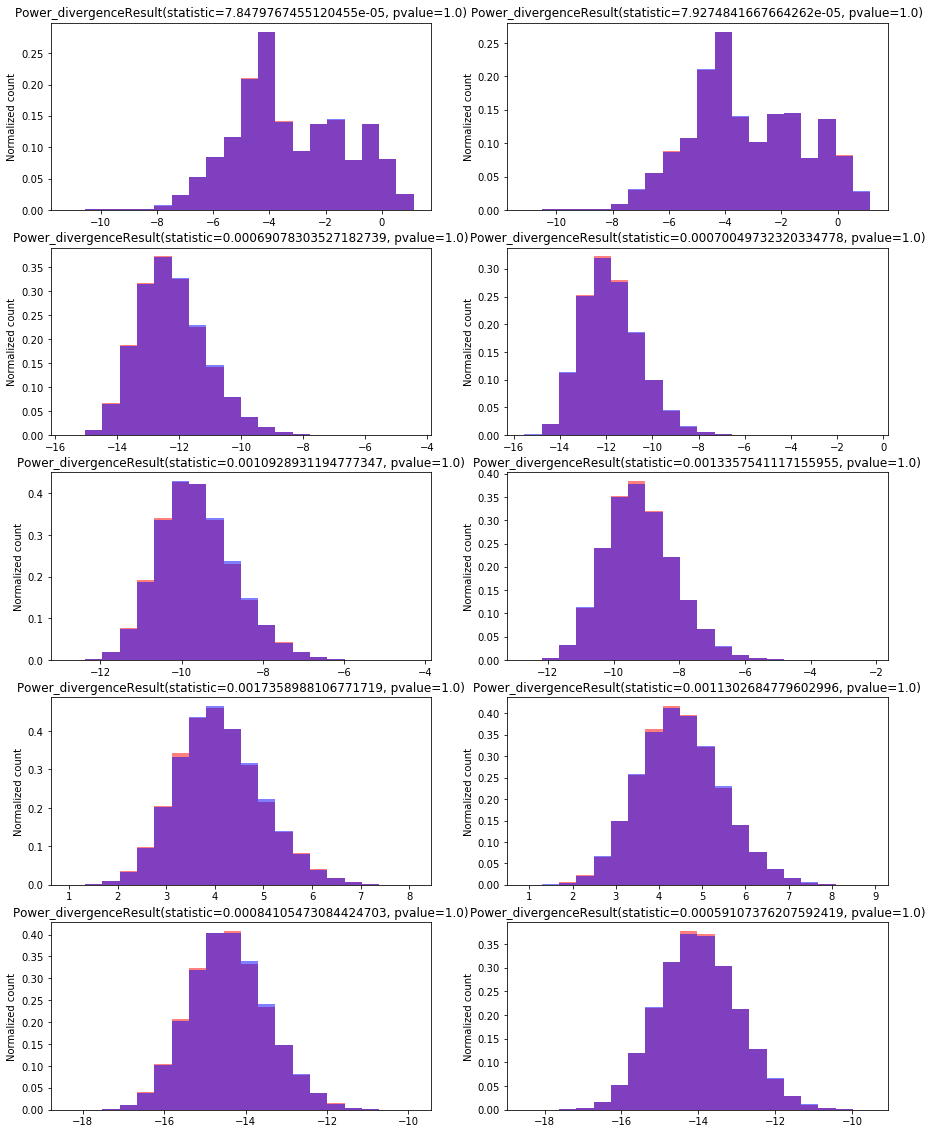

In [9]:
top_of_res = 2835
top_of_noise = 1000

f, ax = plt.subplots(5, 2, figsize = (15, 20))

for i in range(5):
    
    n1, n2 = train_test_split(fdata[i][:, top_of_noise:top_of_res].T, test_size = 0.5, random_state = 50)
    t1, t2 = train_test_split(fdata[i][:, top_of_res:].T, test_size = 0.5, random_state = 50)
    
    hist, bins, patches = ax[i][0].hist(10*np.log10(n1.flatten()), bins = 20, alpha = 0.5, normed=True, color = 'red')
    ax[i][0].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i][0].hist(10*np.log10(n2.flatten()), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i][0].set_title(chisquare(mhist, f_exp = hist))
    
    hist, bins, patches = ax[i][1].hist(10*np.log10(t1.flatten()), bins = 20, alpha = 0.5, normed=True, color = 'red')
    ax[i][1].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i][1].hist(10*np.log10(t2.flatten()), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i][1].set_title(chisquare(mhist, f_exp = hist))
    
plt.show()

NameError: name 'power_divergence' is not defined

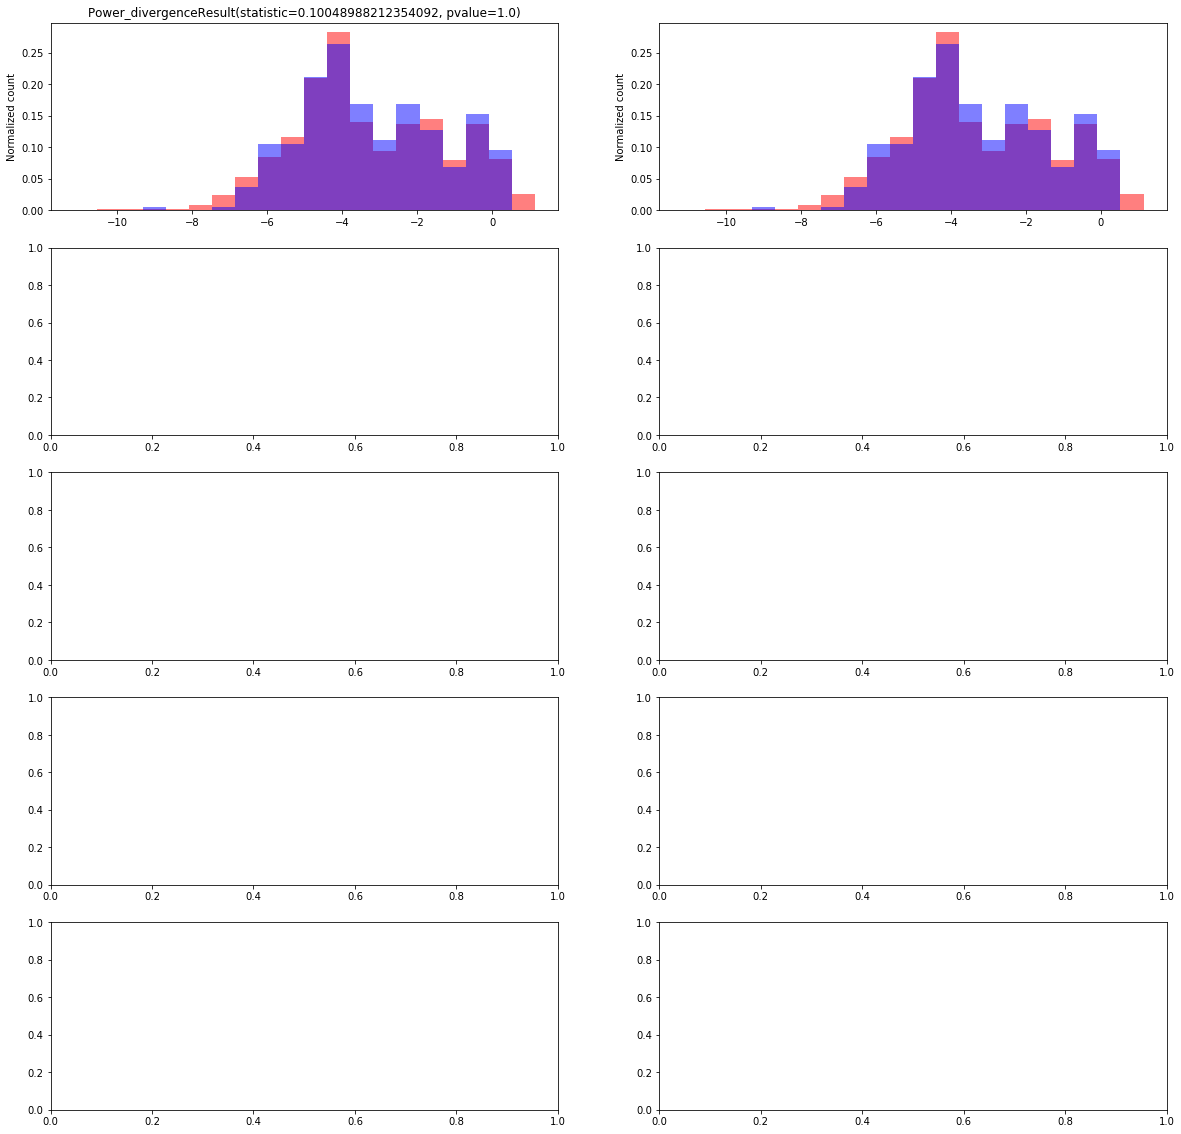

In [10]:
top_of_res = 2835
top_of_noise = 1000

f, ax = plt.subplots(5, 2, figsize = (20, 20))

for i in range(5):
    noise = fdata[i][:, top_of_noise:top_of_res]
    signal = fdata[i][:, 4973]
    
    for j in range(2):
    
        if j == 0:
            hist, bins, patches = ax[i][j].hist(np.nan_to_num(10*np.log10(noise.flatten())), bins = 20, alpha = 0.5, normed=True, color = 'red')
            ax[i][j].set_ylabel('Normalized count')
            #ax[i].set_xlabel('Amplitude (dB)')
            mhist, mbins, mpathces = ax[i][j].hist(np.nan_to_num(10*np.log10(signal.flatten())), bins = bins, alpha = 0.5, normed=True, color = 'blue')
            ax[i][j].set_title(chisquare(mhist, f_exp = hist))
        else:
            hist, bins, patches = ax[i][j].hist(np.nan_to_num(10*np.log10(noise.flatten())), bins = 20, alpha = 0.5, normed=True, color = 'red')
            ax[i][j].set_ylabel('Normalized count')
            #ax[i].set_xlabel('Amplitude (dB)')
            mhist, mbins, mpathces = ax[i][j].hist(np.nan_to_num(10*np.log10(signal.flatten())), bins = bins, alpha = 0.5, normed=True, color = 'blue')
            ax[i][j].set_title(power_divergence(mhist, f_exp = hist, lambda_ = 'cressie-read'))

plt.show()

In [11]:
top_of_res = 2835
top_of_noise = 1000

results = np.zeros((5, fdata[0][:, :].shape[1]))

for i in range(5):
    noise = fdata[i][:, top_of_noise:top_of_res]
    hist, bins = np.histogram(10*np.log10(noise.flatten()), bins = 20, normed=True)
    for n in range(fdata[i][:, :].shape[1]):
        signal = fdata[i][:, n]
        mhist, mbins = np.histogram(10*np.log10(signal.flatten()), bins = bins, normed=True)
        
        results[i, n] = chisquare(mhist, f_exp = hist)[0]

C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\numpy\lib\function_base.py:819: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bins
C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


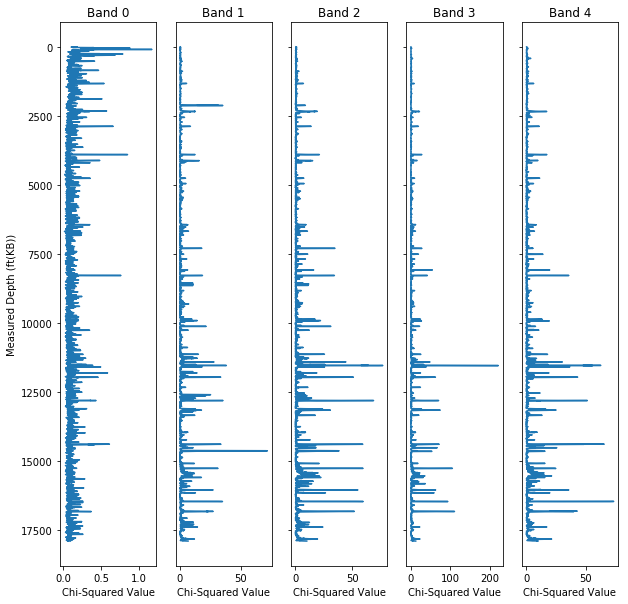

In [12]:
fig, ax = plt.subplots(1, 5, figsize = (10, 10), sharey = True)

data = results[:, 250:]
fig.gca().invert_yaxis()
for i in range(5):
    ax[i].plot(data[i, :], np.arange(data.shape[1]) * 3.28084)
    if i == 0:
        ax[i].set_ylabel('Measured Depth (ft(KB))')
    ax[i].set_xlabel('Chi-Squared Value')
    ax[i].set_title('Band {0}'.format(i))

#fig.gca().invert_yaxis()
plt.show()

In [ ]:
results_nonzero = np.nan_to_num(results[:, 1000:])

In [ ]:
from scipy.stats import pearsonr

In [ ]:
print("     |  B0  |  B1  |  B2  |  B3  |  B4")
for i in range(5):
    f = []
    for j in range(5):
        f.append(pearsonr(results_nonzero[i, :], results_nonzero[j, :]))
        
    print("B{0} - | {1:.2f} | {2:.2f} | {3:.2f} | {4:.2f} | {5:.2f}".format(
            i, f[0][0], f[1][0], f[2][0], f[3][0], f[4][0]))

In [ ]:
data = results_nonzero[1:4, :].mean(axis = 0)
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(data[3000:], np.arange(data.shape[0])[3000:])
fig.gca().invert_yaxis()
plt.show()

In [ ]:
merged['b1'] = 0
merged['b2'] = 0
merged['b3'] = 0
merged['b4'] = 0

for n in range(4):
    merged.ix[:5707, 'b{0}'.format(n+1)] = results[n+1, :]

In [ ]:
r = merged.iloc[2700:5900]

perf_depths = merged.loc[merged['Pstring'] != 'Pnan-nan', 'MD'].values * 3.28084
perf_shots = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Shots'].values
perf_labels = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Pstring'].values

fig, ax = plt.subplots(figsize = (10, 100))
fig.gca().invert_yaxis()
fig.gca().yaxis.grid(b = True, which = 'major', color = 'black', linestyle = '-')
fig.gca().yaxis.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

for i, group in r.groupby('Stage'):
    ax.scatter(group['Shots'], group['Measured Depth (mKB)'] * 3.28084)
    
for i, label in enumerate(perf_labels):
    ax.annotate(label, (perf_shots[i], perf_depths[i]))
    
ax.set_xlabel('Shots per Cluster')
ax.set_ylabel('Measured Depth (ftKB)')
ax2 = ax.twiny()
ax2.set_xlabel('Mean Chi-Squared - Bands 1:3')
ax2.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'] * 3.28084)
ax2.set_xlim([0,100])
ax2.minorticks_on()
ax2.yaxis.grid(True)
ax2.grid(b = True, which = 'major', color = 'black', linestyle = '-')
ax2.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

ax3 = ax.twiny()
ax3.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'] * 3.28084, linestyle = '--')
ax3.set_xlim([100, 200])
ax3.xaxis.set_visible(False)
ax4 = ax.twiny()
ax4.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'] * 3.28084, linestyle = '-')
ax4.set_xlim([200, 300])
ax4.xaxis.set_visible(False)


plt.show()

In [ ]:
r = merged

perf_depths = merged.loc[merged['Pstring'] != 'Pnan-nan', 'MD'].values
perf_shots = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Shots'].values
perf_labels = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Pstring'].values

fig = plt.figure(figsize = (10, 100))
gs1 = gridspec.GridSpec(1, 5)
ax1 = fig.add_subplot(gs1[:, :1])
ax4 = fig.add_subplot(gs1[:, 1:], sharey = ax1)

fig.gca().yaxis.grid(b = True, which = 'major', color = 'black', linestyle = '-')
fig.gca().yaxis.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

for i, group in r.groupby('Stage'):
    ax1.scatter(group['Shots'], group['Measured Depth (mKB)'])
    
for i, label in enumerate(perf_labels):
    ax1.annotate(label, (perf_shots[i], perf_depths[i]))

    
ax2 = ax1.twiny()
ax2.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'])
ax2.set_xlim([0,100])
ax2.minorticks_on()
ax2.yaxis.grid(True)
ax2.grid(b = True, which = 'major', color = 'black', linestyle = '-')
ax2.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

ax3 = ax1.twiny()
ax3.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'], linestyle = '--')
ax3.set_xlim([100, 200])
ax3.xaxis.set_visible(False)

image = pd.DataFrame(data = fdata[1].value, columns = merged.ix[:fdata[1].shape[1] - 1, 'Measured Depth (mKB)'])

ax4.imshow(10*np.log10(image).T, aspect = 'auto', extent=[0, len(image.index), image.columns[-1], image.columns[0]], cmap = 'viridis', vmin = -20, vmax = -5)

plt.show()

In [ ]:
ax = scatter_matrix(merged.loc[2750:, ['b1', 'b2', 'b3', 'b4']], alpha=0.5, figsize=(20, 20), diagonal='kde', grid='minor')
plt.show()

In [ ]:
merged.head()

In [ ]:
merged['ChiMean'] = merged.loc[:, ['b1', 'b2', 'b3']].mean(axis = 1)

In [ ]:
merged['ChiMeanNorm'] = normalize(merged['ChiMean'].fillna(0.0).values.reshape(1, -1), norm = 'max')[0]

In [ ]:
merged.to_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\{0}-{1}-Result.csv'.format(starttime.strftime('%Y-%m-%d %H%M%S'), endtime.strftime('%Y-%m-%d %H%M%S')))

In [ ]:
chisquare?

In [ ]:
from scipy.stats import power_divergence

In [ ]:
power_divergence?